In [ ]:
!pip install transformers torch datasets

In [ ]:
from datasets import load_dataset

data = load_dataset(
    "jamescalam/image-text-demo",
    split="train"
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


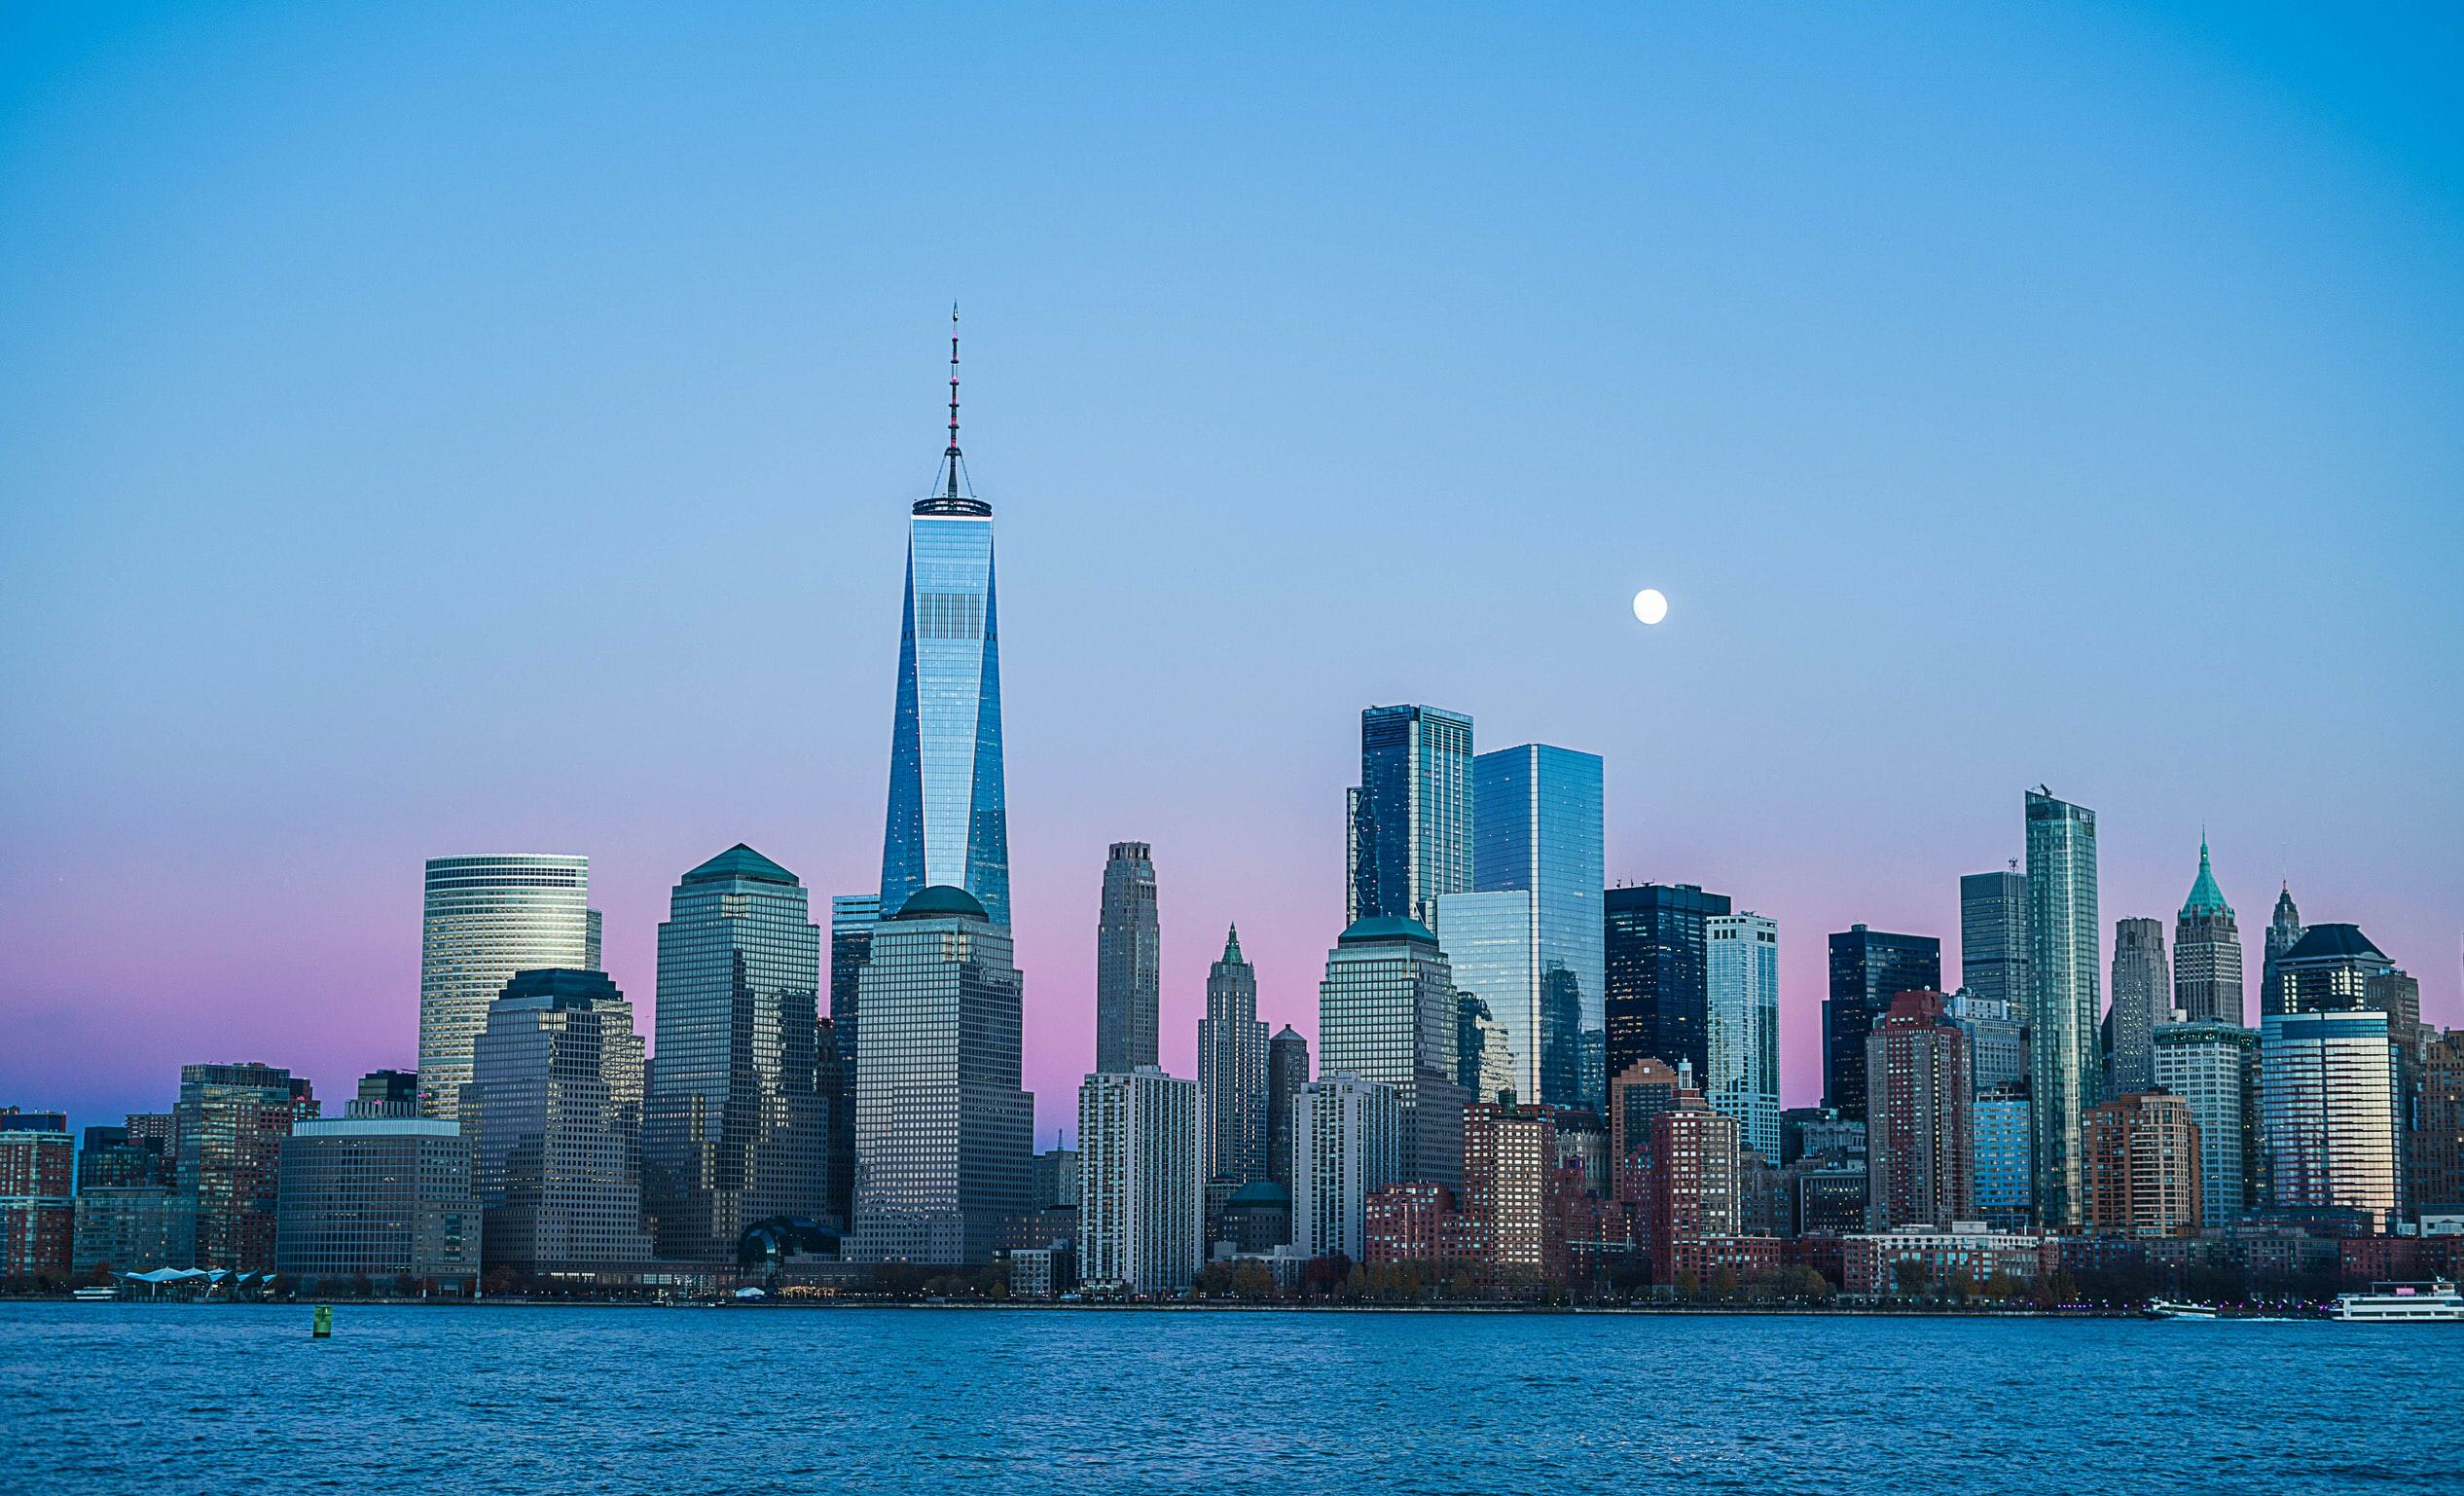

In [ ]:
data[12]['image']

In [ ]:
from transformers import CLIPProcessor, CLIPModel
import torch

model_id = "openai/clip-vit-base-patch32"

processor = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id)

# move model to device if possible
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.to(device)

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

In [ ]:
text = data['text']  # 21

tokens = processor(
    text=text,
    padding=True,
    images=None,
    return_tensors='pt'
).to(device)
tokens.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
text_emb = model.get_text_features(
    **tokens
)

In [ ]:
print(text_emb.shape)
print(text_emb.min(), text_emb.max())

torch.Size([21, 512])
tensor(-1.1893, device='cuda:0', grad_fn=<MinBackward1>) tensor(4.8015, device='cuda:0', grad_fn=<MaxBackward1>)


In [ ]:
# IF using dot product similarity, must normalize vectors like so...
import numpy as np

# detach text emb from graph, move to CPU, and convert to numpy array
text_emb = text_emb.detach().cpu().numpy()

# calculate value to normalize each vector by
norm_factor = np.linalg.norm(text_emb, axis=1)
norm_factor.shape

(21,)

In [ ]:
text_emb = text_emb.T / norm_factor
# transpose back to (21, 512)
text_emb = text_emb.T
print(text_emb.shape)
print(text_emb.min(), text_emb.max())

(21, 512)
-0.15268452 0.5344988


In [ ]:
data['image'][0].size

(6000, 3376)

In [ ]:
image_batch = data['image']

images = processor(
    text=None,
    images=image_batch,
    return_tensors='pt'
)['pixel_values'].to(device)
images.shape

torch.Size([21, 3, 224, 224])

In [ ]:
img_emb = model.get_image_features(images)
print(img_emb.shape)
print(img_emb.min(), img_emb.max())

torch.Size([21, 512])
tensor(-8.6561, device='cuda:0', grad_fn=<MinBackward1>) tensor(2.6768, device='cuda:0', grad_fn=<MaxBackward1>)


In [ ]:
# NORMALIZE
# detach text emb from graph, move to CPU, and convert to numpy array
img_emb = img_emb.detach().cpu().numpy()

img_emb = img_emb.T / np.linalg.norm(img_emb, axis=1)
# transpose back to (21, 512)
img_emb = img_emb.T
print(img_emb.shape)
print(img_emb.min(), img_emb.max())

(21, 512)
-0.7277218 0.2359628


In [ ]:
from numpy.linalg import norm

cos_sim = np.dot(text_emb, img_emb.T) / (
    norm(text_emb, axis=1) * norm(img_emb, axis=1)
)
cos_sim.shape

(21, 21)

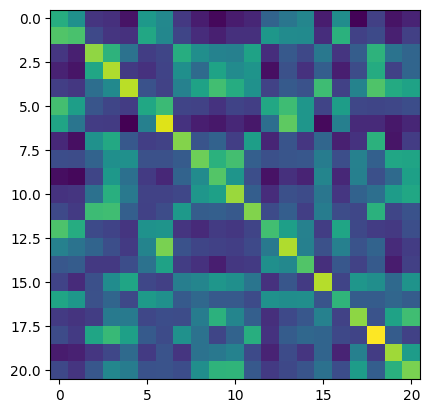

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(cos_sim)
plt.show()

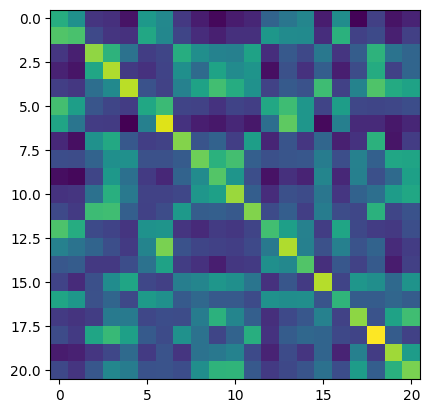

In [ ]:
dot_sim = np.dot(text_emb, img_emb.T)

plt.imshow(cos_sim)
plt.show()

In [ ]:
diff = cos_sim - dot_sim
diff.min(), diff.max()

(-2.9802322e-08, 5.9604645e-08)